In [974]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from scipy.stats import norm
from lmfit import Model

# my plotting style, please use your own!
plt.style.use('~/Documents/code/stylelib/madx.mplstyle')

In [975]:
# parameters
amu_mev = 931.49410242 # MeV
beam_energy = 200.0 # MeV/u
circumference = 60.35075196 # from madx, not geometrical
n_turns = 1 # full turns of the ring (for twiss calculation)
dp_modifier = 0.0 # adjusts k0 of the dipole which alters the bending strength
n_turns_ptc = 2000 # number of turns for ptc

In [976]:
# initialise madx
madx = Madx()
madx.command.title('R3 Position Check for Position Schottky 2024')

# input n_turns for sequence file
madx.input(f'n_turns = {n_turns};')
madx.input(f'dp_modifier = {dp_modifier};')
# call sequence
madx.call(file='r3_center.seq')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.08.16 16:33:35      +
  ++++++++++++++++++++++++++++++++++++++++++++
! r3 ring sequence with refer = center for use of makethin command etc.

! G.Hudson-Chang June 2024



! ===== parameters =====

full_gap = 0.08; ! Full width pole to pole gap [m]

b_angle = 15*raddeg; ! Bending angle [rad.]

b_rad_tarnd = 4.045; ! Bending radius of TARNII-D [m]



! ===== lengths =====

l_dp = b_rad_tarnd*b_angle; ! length of dipole

l_dp_drft = 0.6; ! drift section between R3 dipoles



l_str = 4.022544566; ! straight section

l_str_hf = 2.011272283; ! half straight section



l_r3_bend = 4*l_dp+3*l_dp_drft; ! length of r3_bend section

l_r3_bend_hf = l_r3_bend/2; ! length of r3_bend section

l_ring = 6*l_r3_bend+6*l_str;



! ===== dipole magnets =====

! ring dipole with trim coil

dp_tr

In [977]:
# initialise beam
madx.command.beam(
    mass = 70*amu_mev/1000, # input is GeV
    charge = 30.0,
    energy = 70*(amu_mev+beam_energy)/1000, # also GeV
    sigt = 4.4616, # bunch length
    sige = 0.001, # rel energy spread
    kbunch = 18, # n bunches in machine
    radiate = True, # synchrotron radiation
    bunched = True,
)

True

In [978]:
# use the beam in the sequence
madx.use(sequence = 'full_ring')

In [979]:
# matching - copied from old ring file by Y. Yamaguchi
madx.command.match(sequence = 'full_ring')
madx.command.constraint(mux = 1.216)
madx.command.vary(NAME = 'dp_trim->k2', step = 0.001, lower = -1.0, upper = 1.0)
madx.command.simplex(calls = 100000, tolerance = 1.0e-12)
madx.command.endmatch()

# use after match
madx.use(sequence='full_ring')

START MATCHING

number of sequences: 1
sequence name: full_ring
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
number of variables:    1
user given constraints: 1
total constraints:      74

START SIMPLEX:

++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed o

In [980]:
# tracking with ptc module

# invoke ptc tracking module
madx.command.ptc_create_universe()
# create layout
madx.command.ptc_create_layout(
    model = 2, # matrix-kick-matrix model
    method = 6, # integration order
    nst = 10, # no. of integration steps for each element
)
# additional options
madx.command.ptc_setswitch(
    fringe = True, # fringe field effects
    radiation = False, # synchrotron radiation
    time = True, # changes canonical coords (p.212 of manual)
    totalpath=True,
    debuglevel = 2,
)
# add observation point
madx.command.ptc_observe(place = 'bpm_schottky')

Determined SECTOR NMUL MAX :  3
 MAD-X Beam Parameters
                  Energy : 0.792046E+02
          Kinetic Energy : 0.140000E+02
      Particle Rest Mass : 0.652046E+02
                Momentum : 0.449636E+02
 Cannot do spin : provide a=g-2. Now it is set to zero.
 Setting MADx with 
     energy           79.204587169400000     
     method                   6
     Num. of steps           10
     charge           1.0000000000000000     
  Length of machine:    60.350751963541470     
 The machine is a RING
 ------------------------------------ PTC Survey ------------------------------------
 Before start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 Before   end:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After  start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After    end:    3.5122108657538453E-014   0.0000000000000000       -1.2434497875801753E-014
 Setting debug level

True

In [981]:
# initialise particles with normal distribution
n_particles = 200  # number of particles
for i in range(n_particles):
    madx.command.ptc_start(
        x=np.random.normal(0, 0.08), # mean and std. dev.
        px=np.random.normal(0, 0.01), # mean and std. dev.
        pt=0.002 # energy error
    )

In [982]:
madx.command.ptc_track(
        icase = 6, # phase space dimensionality, affects ptc_setswitch(time, totalpath)
        closed_orbit = True,
        element_by_element = True,
        turns = n_turns_ptc,
        maxaper = [0.24, 0.03, 0.05, 0.01, 1.0, 0.1], # maximum aperture
        file = 'data/tracker/r3',
        extension = '.out',
        ffile =2 , # periodicity of printout to file
)

++++++ warning: my_state:   no cavity - dimensionality reduced 6 -> 5 and 1/2
 ************ State Summary ****************
 MADTHICK=>KIND =   37  MATRIX-KICK-MATRIX     
  Rectangular Bend: input arc length (rho alpha) 
  Default integration method     6
  Default integration steps     10
 This a particle with    127602.19403465     times the electron mass 
       EXACT_MODEL =  FALSE
       TOTALPATH   =     1
       RADIATION   =  FALSE
       STOCHASTIC  =  FALSE
       ENVELOPE    =  FALSE
       NOCAVITY    =  TRUE 
       TIME        =  TRUE 
       FRINGE      =  TRUE 
       PARA_IN     =  FALSE
       ONLY_2D     =  FALSE
       ONLY_4D     =  FALSE
       DELTA       =  FALSE
       SPIN        =  FALSE
       MODULATION  =  FALSE
       RAMPING     =  FALSE
       ACCELERATE  =  FALSE
  Radiation_PTC    =      F
 ************ State Summary ****************
 MADTHICK=>KIND =   37  MATRIX-KICK-MATRIX     
  Rectangular Bend: input arc length (rho alpha) 
  Default integration

True

In [983]:
# read data
xdata = []
pxdata = []
empty_files = 0
for i in range(n_particles):
    current_file = np.transpose(np.loadtxt(f'data/tracker/r3.obs0001.p{i+1:04d}.out', skiprows=8, usecols=(2,3)))
    if current_file.size > 2: # arrays of size 1 cause errors in .ravel()
        xdata.append(current_file[0])
        pxdata.append(current_file[1])
    else:
        empty_files+=1

In [984]:
# join and flatten arrays
xdata = (np.concatenate(xdata).ravel())*1000
pxdata = np.concatenate(pxdata).ravel()

In [985]:
# plot parameters
nbins = 200
colormap = 'magma'
xmin, xmax = -240, 240

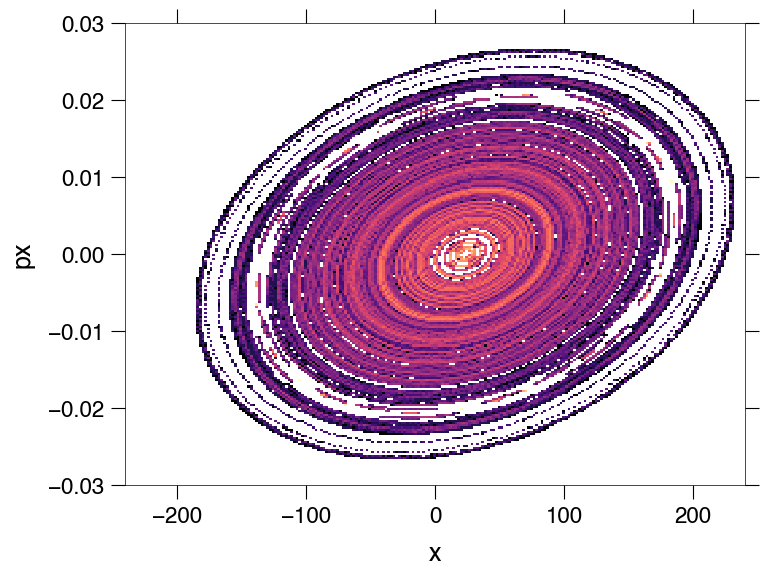

In [986]:
# plot: x phase space
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.hist2d(
    xdata, pxdata,
    bins=nbins,
    norm=matplotlib.colors.LogNorm(), # log scale
    cmap=colormap
)

ax.set_xlim([xmin,xmax])
ax.set_ylim([-0.03,0.03])

ax.set_xlabel('x')
ax.set_ylabel('px')

plt.savefig(f'plots/x_phasespace.pdf', bbox_inches='tight')

In [987]:
# initiate fitting with lmfit
# Gaussian
def gaussian(x, amp, cen, sigma):
    return (amp * np.exp(-(x-cen)**2 / (2*sigma**2)))
gmodel = Model(gaussian)

# Lorentzian
def lorentzian(x, amp, cen, sigma):
    return (amp / (np.pi * sigma)) * (1 / (1 + ((x - cen) / sigma) ** 2))
lmodel = Model(lorentzian)

# data for fit
hist, bin_edges = np.histogram(xdata, bins=nbins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

mu, std = norm.fit(xdata)
result = lmodel.fit(hist, x=bin_centers, amp=1000, cen=mu, sigma=std )
result

In [988]:
cen_val = result.params['cen'].value
cen_err = result.params['cen'].stderr

sig_val = result.params['sigma'].value
sig_err = result.params['sigma'].stderr


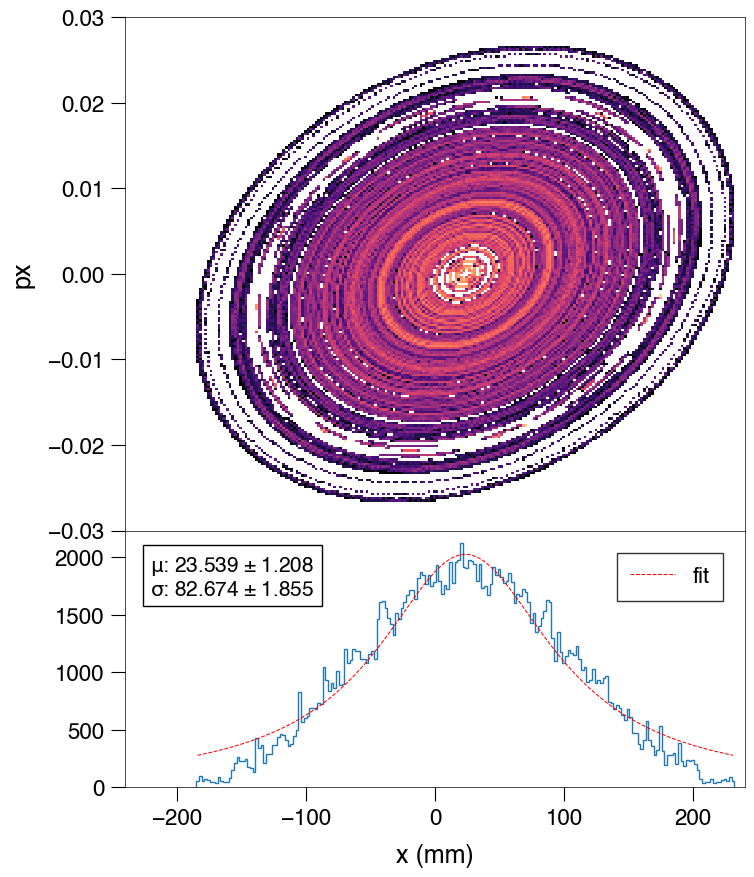

In [989]:
# plot: x phase space with x projection
fig = plt.figure(figsize=(8, 10),)
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2, 1])
ax = gs.subplots(sharex=True)

# plot phasespace
ax[0].hist2d(
    xdata, pxdata,
    bins=nbins,
    norm=matplotlib.colors.LogNorm(), # log scale
    cmap=colormap
)

ax[1].hist(xdata, bins=nbins, histtype='step')
ax[1].plot(
    np.linspace(bin_centers[0], bin_centers[-1], nbins), result.best_fit,
    color='red',
    linestyle='--',
    label='fit',
)

# settings
ax[1].set_xlabel('x (mm)')
ax[0].set_ylabel('px')

ax[0].set_ylim([-0.03,0.03])
for axA in ax:
    axA.tick_params(right=False, top=False)
    axA.set_xlim([xmin,xmax])

ax[1].text(
    0.04, 0.75, 
    f'$\mu$: {cen_val:0.3f} ± {cen_err:0.3f} \n$\sigma$: {sig_val:0.3f} ± {sig_err:0.3f}',
    fontsize='small',
    transform = ax[1].transAxes, # relative coord scale
    bbox=dict(facecolor='none', pad=5.0),
)

ax[1].legend()

plt.savefig(f'plots/x_phasespace_xproj.pdf', bbox_inches='tight')